In [1]:

import math
import ipywidgets as widgets
import numpy as np
import copy
import random

import pickle

import datetime


import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.integrate as integrate

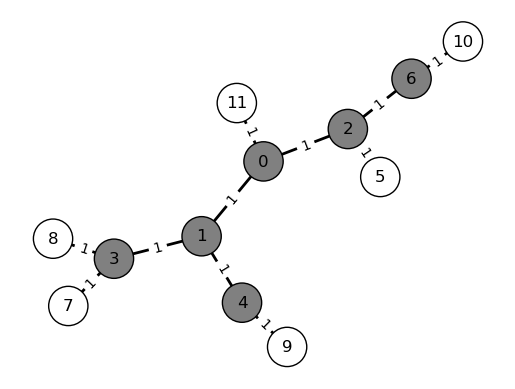

In [2]:

# seed used in "nx.spring_layout(G, seed=pos_SEED)"
pos_SEED=0


# Create an empty tree graph
G = nx.Graph()

# Add 10 nodes to the graph
G.add_nodes_from(range(11))

# Connect the nodes in a tree structure
G.add_edges_from([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9),(6,10),(0,11)])

for e in G.edges(data=True):
    G[e[0]][e[1]]["weight"]=1

edge_labels = nx.get_edge_attributes(G,'weight')
    
nodes_infected={0,1,2,3,4,6}


# Set the node colors
node_colors = ['gray' if i in nodes_infected else 'white' for i in range(G.number_of_nodes())]

# Draw the graph
pos = nx.spring_layout(G, seed=pos_SEED)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors= 'black')
nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in range(G.number_of_nodes())}, font_size=12)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.axis('off')
plt.show()

In [3]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 1}), (0, 2, {'weight': 1}), (0, 11, {'weight': 1}), (1, 3, {'weight': 1}), (1, 4, {'weight': 1}), (2, 5, {'weight': 1}), (2, 6, {'weight': 1}), (3, 7, {'weight': 1}), (3, 8, {'weight': 1}), (4, 9, {'weight': 1}), (6, 10, {'weight': 1})])

In [4]:
a=np.float64(800)
b=np.exp(-a)
print(type(a), type(b),a,b)


<class 'numpy.float64'> <class 'numpy.float64'> 800.0 0.0


In [5]:
import sys

sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

NetworkXError: Input is not a valid edge list

In [7]:
# from scipy.stats import gamma
# gamma.pdf(x,a)

In [8]:
DEBUG_LEVEL=10

In [479]:
"""
Construct the parent and child relation between nodes after selecting a node as source.
"""
# source=0
source = list(nodes_infected)[0]
def parent_child_relation(G, nodes_infected, source):
    parent={} # 'key:value' pair where 'value' is the parent node for node 'key'
    child={} #'key:value' pair where 'value' is the set of child nodes for node 'key'
    depth={} # 
    nodes_waiting_child=set() # nodes haven't assigned child
    b_uninfected=set() #susceptible nodes at final observation; uninfected nodes which have infected neighbors
    b_infected=set() #infected nodes which have uninfected neighbors
    leaf_infected=set() # the leaf infected nodes

    leaf_uninfected=set() # the uninfected nodes whoes parent is in leaf_infected
    pseudo_leaf_uninfected=set() # the uninfected nodes whoes parent is infected but not in leaf_infected

    parent[source]=None
    depth[source]=0
    nodes_waiting_child.add(source)
    while len(nodes_waiting_child)!=0:
        i=nodes_waiting_child.pop()
        child[i]= set(j for j in G.neighbors(i) if j not in parent.keys())
        if i!=source:
            i_is_leaf_infected = True 
        else:
            i_is_leaf_infected = False
        i_has_infected_child = False
        i_uninfected_child=set()
        for j in child[i]:
            parent[j]=i
            if j in nodes_infected:
                depth[j]=depth[i]+1
                nodes_waiting_child.add(j)
                i_is_leaf_infected = False
                i_has_infected_child = True
            else:
                b_uninfected.add(j)
                i_uninfected_child.add(j)
        if i_has_infected_child==True:
            b_infected.add(i)
        if i_is_leaf_infected==True:
            leaf_infected.add(i)
            leaf_uninfected = leaf_uninfected.union(i_uninfected_child)
        # print(i, child[i])
        
    #### pay attention to the uninfected neighbors of the source.
    root_uninfected_child = child[source].intersection(b_uninfected)
    pseudo_leaf_uninfected = b_uninfected - leaf_uninfected -root_uninfected_child 
    return parent,child,b_uninfected,b_infected,depth,leaf_infected, root_uninfected_child, pseudo_leaf_uninfected


parent,child,b_uninfected,b_infected,depth,leaf_infected, root_uninfected_child, pseudo_leaf_uninfected = parent_child_relation(G=G.subgraph([0]), nodes_infected=nodes_infected, source=source)
    
if DEBUG_LEVEL>9:
    print(parent,child,b_uninfected,b_infected,depth,leaf_infected, root_uninfected_child, pseudo_leaf_uninfected,sep="\n")

{0: None}
{0: set()}
set()
set()
{0: 0}
set()
set()
set()


In [363]:

def fhat(t,k,d,T2):
    return (t**(k-1)*np.exp(-t)/math.factorial(k-1))*np.exp(-(T2-t)*(d-1))

def fhat_integral(T1, T2, k, d):
    # print("T1, T2, k, d",T1, T2, k, d)
    return integrate.quad(fhat, T1, T2, args=(k,d,T2))

In [470]:
tmax=4
gr_main=G 
gr_nodes_infected=nodes_infected
gr_nodes_susceptible=b_uninfected


# def compute_likelihood(G, nodes_infected, source, tmax):
def compute_likelihood(tmax, gr_main, gr_nodes_infected, gr_nodes_susceptible, tcount=21, dynamic_scale=False):

    t_list = np.linspace(0, tmax, tcount)
    t_positions=[i for i in range(len(t_list))]

    
    result=[{} for i in t_positions]
    scale_num=[{} for i in t_positions]
    for source in gr_nodes_infected:
        message=[{} for i in t_positions]
        
        G=extract_bfs(gr_main, gr_nodes_infected, gr_nodes_susceptible, s_selected=source)
        
        parent,child,b_uninfected,b_infected,depth,leaf_infected, root_uninfected_child, pseudo_leaf_uninfected = parent_child_relation(G=G, nodes_infected=gr_nodes_infected, source=source)

        for t_pos in t_positions:
            for i in leaf_infected:
                if depth[i]==0:
                    print(gr_nodes_infected, gr_nodes_susceptible, gr_main.edges(),'\n', 'i', i, 't_list[t_pos], depth[i], G.degree[i]', t_list[t_pos], depth[i], G.degree[i])
                message[t_pos][i]=fhat_integral(0, t_list[t_pos], depth[i], G.degree[i])[0]
                
            for i in pseudo_leaf_uninfected:
                message[t_pos][i]=fhat_integral(0, t_list[t_pos], depth[parent[i]], 2)[0]

            for i in root_uninfected_child:
                message[t_pos][i]=math.exp(-t_list[t_pos])
            
            if dynamic_scale==True:
                scale_num[t_pos][source]=0
                result[t_pos][source]=1
                for m in message[t_pos].values():
                    if result[t_pos][source]<10**(-6):
                        result[t_pos][source]=result[t_pos][source]*10**20
                        scale_num[t_pos][source]+=1
                    result[t_pos][source]=result[t_pos][source]*m
            else:
                result[t_pos][source]=np.prod(list(message[t_pos].values()))
                # result[t_pos][source]=np.prod([10**300]+list(message[t_pos].values()))

                
            
            ## to save memory
            # print(max(message[t_pos].values()))
            message[t_pos]={}
            
    if dynamic_scale==True:
        scale_num_min=min([min(scale_num[t_pos].values()) for t_pos in t_positions])
        for t_pos in t_positions:
            for k,v in result[t_pos].items():
                result[t_pos][k]=v*10**(-20*(scale_num[t_pos][k]-scale_num_min))
        # print(scale_num)
        
            
    return result, t_positions

result, t_positions = compute_likelihood(tmax=tmax, gr_main=G, 
                                         gr_nodes_infected=gr_nodes_infected,gr_nodes_susceptible=gr_nodes_susceptible)
# result, t_positions = compute_likelihood(tmax=tmax, gr_main=G, gr_nodes_infected=gr_nodes_infected,gr_nodes_susceptible=gr_nodes_susceptible,dynamic_scale=True)

# if DEBUG_LEVEL>9:
#     print(message)
    
print(result)
    

[{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 6: 0.0}, {0: 5.512527180038593e-07, 1: 7.113091120985628e-08, 2: 2.4902925246965718e-08, 3: 1.0709127534656079e-11, 4: 1.2250060400085766e-11, 6: 6.286952848350945e-12}, {0: 2.4362965369458917e-05, 1: 6.091752782124401e-06, 2: 2.235800424932911e-06, 3: 6.605879763083269e-09, 4: 8.66238768691873e-09, 6: 4.558064402423183e-09}, {0: 0.00014402892074685743, 1: 5.2402493363508925e-05, 2: 2.01239925906481e-05, 3: 1.7210010525761922e-07, 4: 2.5925205734434356e-07, 6: 1.3970979121781276e-07}, {0: 0.0003740974507027, 1: 0.0001762637353620018, 2: 7.069068892142223e-05, 3: 1.2273088343713038e-06, 4: 2.1281988306642496e-06, 6: 1.173309993270518e-06}, {0: 0.0006196880441665896, 1: 0.00035493290186825913, 2: 0.00014837022047939588, 3: 4.303389195601317e-06, 4: 8.606778391202634e-06, 6: 4.849371742455613e-06}, {0: 0.0007728325304870868, 1: 0.0005172221061051092, 2: 0.0002249297469577011, 3: 9.630546962860078e-06, 4: 2.225757687802811e-05, 6: 1.280354879194844

In [58]:
result, t_positions = compute_likelihood(tmax=tmax, gr_main=G, gr_nodes_infected=gr_nodes_infected,gr_nodes_susceptible=gr_nodes_susceptible,dynamic_scale=True)

print(result)

[{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 6: 0.0}, {0: 5.512527180038593e-07, 1: 7.113091120985628e-08, 2: 2.4902925246965718e-08, 3: 1.0709127534656079e-11, 4: 1.2250060400085766e-11, 6: 6.286952848350944e-12}, {0: 2.4362965369458917e-05, 1: 6.091752782124401e-06, 2: 2.235800424932911e-06, 3: 6.605879763083269e-09, 4: 8.66238768691873e-09, 6: 4.558064402423183e-09}, {0: 0.00014402892074685743, 1: 5.2402493363508925e-05, 2: 2.01239925906481e-05, 3: 1.7210010525761922e-07, 4: 2.592520573443435e-07, 6: 1.3970979121781276e-07}, {0: 0.0003740974507027, 1: 0.0001762637353620018, 2: 7.069068892142223e-05, 3: 1.2273088343713038e-06, 4: 2.1281988306642496e-06, 6: 1.173309993270518e-06}, {0: 0.0006196880441665896, 1: 0.00035493290186825913, 2: 0.00014837022047939588, 3: 4.303389195601317e-06, 4: 8.606778391202634e-06, 6: 4.849371742455613e-06}, {0: 0.0007728325304870868, 1: 0.0005172221061051092, 2: 0.0002249297469577011, 3: 9.630546962860078e-06, 4: 2.225757687802811e-05, 6: 1.2803548791948441

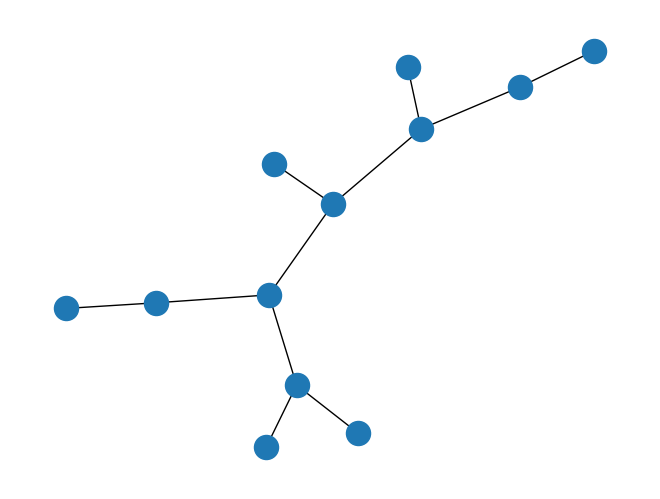

In [12]:
nx.draw(G)

In [55]:
def extract_max_nodes(result, nodes_infected=gr_nodes_infected):
    result_by_node={}
    for i in nodes_infected:
        result_by_node[i]=[]
        for t_pos in t_positions:
            result_by_node[i].append(result[t_pos][i])
            
    max_nodes_t_pos={}
    max_value=0
    max_nodes=set()

    for k,v in result_by_node.items():
        max_index=np.argmax(v)
        max_nodes_t_pos[k]=max_index
        if np.isclose(v[max_index],max_value):
            max_nodes.add(k)
        elif v[max_index]>max_value:               
            max_value=v[max_index]
            max_nodes={k}
    return max_nodes,max_value
    
max_nodes,max_value=extract_max_nodes(result,nodes_infected=gr_nodes_infected)

In [14]:
## store the likelyhood with nodes as keys of a dict. 'result_by_node[i][j]' is the likehood for node i to be the source when observation time is the T_positions[j]-th observation time
result_by_node={}
for i in nodes_infected:
    result_by_node[i]=[]
    for t_pos in t_positions:
        result_by_node[i].append(result[t_pos][i])

if DEBUG_LEVEL>9:
    print(result_by_node)

NameError: name 't_positions' is not defined

In [15]:
## 'max_nodes_t_pos' is a dict; max_nodes_t_pos[i][j] is an integer such that at max_nodes_t_pos[i][j]-th observation time is when node i achives largest likelyhood probability to be the source over all the ovservation times
## 'max_node' are the node has the largest likelyhood probability to be the source, and 'max_value' is the value.
max_nodes_t_pos={}
max_value=0
max_nodes=set()

for k,v in result_by_node.items():
    max_index=np.argmax(v)
    max_nodes_t_pos[k]=max_index
    if np.isclose(v[max_index],max_value):
        max_nodes.add(k)
    elif v[max_index]>max_value:               
        max_value=v[max_index]
        max_nodes={k}

print(max_nodes_t_pos)
print('The most likely source nodes are:', max_nodes, '\n', 'the corresponding likelyhood probability value is', max_value, '\n', 
          'the index of the ovservation time correspond to node', list(max_nodes)[0], ' is ', max_nodes_t_pos[list(max_nodes)[0]])


ValueError: attempt to get argmax of an empty sequence

In [16]:
result_by_t_pos={}

for t_pos in t_positions:
    result_by_t_pos[t_pos]=[]
    for k in G.nodes():
        result_by_t_pos[t_pos].append(result_by_node[k][t_pos] if k in nodes_infected else 0)

result_by_t_pos

NameError: name 't_positions' is not defined

In [17]:
colors_dict=copy.deepcopy(result_by_t_pos)
norm = mpl.colors.Normalize(vmin=0, vmax=max_value, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)

In [18]:
def plot_result_by_t_pos(t_pos_for_plot):
    nx.draw(G, pos=pos, node_color=[mapper.to_rgba(i) for i in colors_dict[t_pos_for_plot]], with_labels=True)
    plt.show()

In [19]:
widgets.interact(plot_result_by_t_pos,t_pos_for_plot=widgets.IntSlider(min=0, max=max(t_positions), step=1, value=1,description="index of the observation time",style={'description_width': 'initial'},layout=widgets.Layout(width='500px')))

print("the darker the node color, the larger probability for the node to be the source")

NameError: name 't_positions' is not defined

In [20]:
gnp_SEED=0
n=15
p=0.3

gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)

In [21]:
s_real=random.choice(list(gnp.nodes()))
print(s_real)
gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)


s_bfs=nx.bfs_tree(gnp, s_real)


1


In [22]:
gtemp=nx.Graph()
gtemp.add_node(s_real)
e_candidate=set(nx.edge_boundary(gnp, gtemp))
while e_candidate:
    gtemp.add_edges_from(e_candidate)
    e_candidate=set(nx.edge_boundary(gnp, gtemp))

size_s_real_connected = gtemp.size()


In [23]:
# target_proportion=random.uniform(0.2,0.5)
# target_size=int(size_s_real_connected*target_proportion)

target_infected_num=7 

gr=nx.Graph()
gr.add_node(s_real)
e_candidate=list(nx.edge_boundary(gnp, gr))

while gr.size()<target_infected_num-1 and e_candidate:
    e_selected=random.choice(e_candidate)
    gr.add_edge(*e_selected)
    e_candidate=list(nx.edge_boundary(gnp, gr))
    
gr_nodes_infected=list(gr.nodes())
gr_nodes_susceptible=set()
for e in e_candidate:
    if e[0] in gr_nodes_infected:
        gr_nodes_susceptible.add(e[1])
    else:
        gr_nodes_susceptible.add(e[0])
gr_nodes_susceptible=list(gr_nodes_susceptible)

print(gr_nodes_infected,gr_nodes_susceptible)

[1, 13, 6, 3, 9, 11, 8] [0, 2, 4, 5, 7, 10, 12, 14]


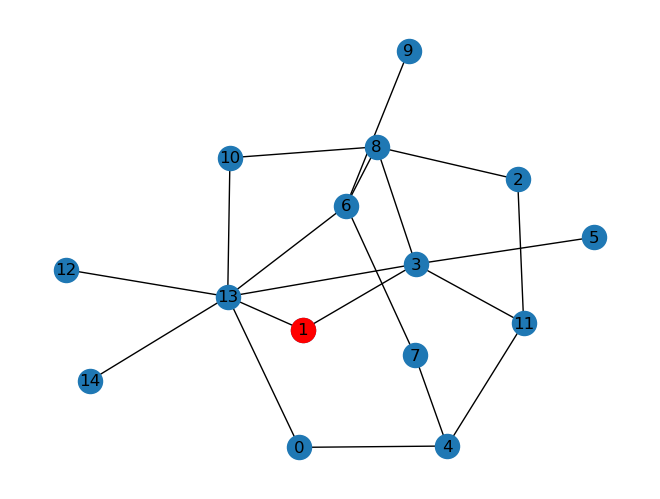

In [24]:
nx.draw(gnp, pos=gnp_pos, with_labels=True)
nx.draw_networkx(gnp.subgraph(s_real), pos=gnp_pos,  node_color='red', with_labels=False)

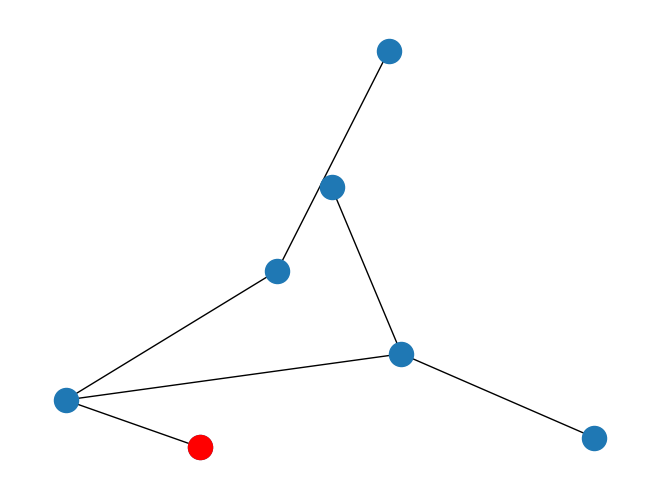

In [25]:
nx.draw(gr, pos=gnp_pos )
nx.draw_networkx(gr.subgraph(s_real), pos=gnp_pos,  node_color='red', with_labels=False)

0 4
4 7


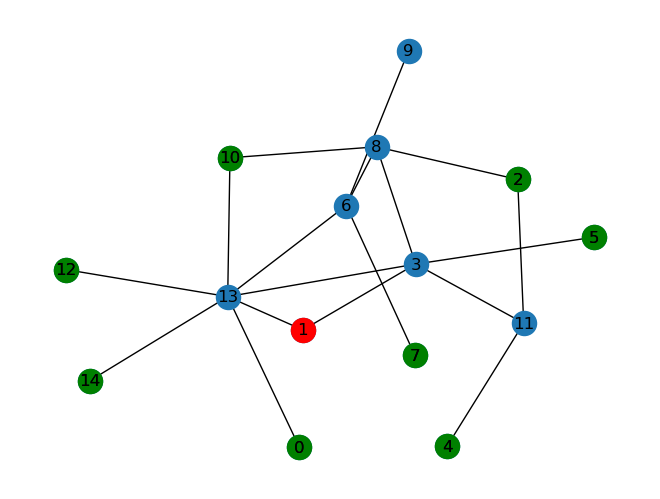

In [26]:
gr_main=gnp.subgraph(gr_nodes_infected + gr_nodes_susceptible).copy()
# remove the edges between susceptible nodes
for u in gr_nodes_susceptible:
    for v in set(gr_main.neighbors(u)).intersection(gr_nodes_susceptible):
        print(u,v)
        gr_main.remove_edge(u,v)
nx.draw(gr_main, pos=gnp_pos, with_labels=True)
nx.draw(gr_main.subgraph(gr_nodes_susceptible), pos=gnp_pos, node_color='green', with_labels=True)
nx.draw_networkx(gnp.subgraph(s_real), pos=gnp_pos,  node_color='red', with_labels=False)

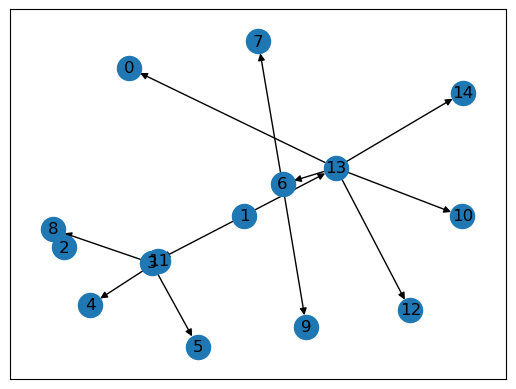

In [27]:
gr_bfs=nx.bfs_tree(gr_main, s_real)
nx.draw_networkx(gr_bfs)

[(2, 8), (2, 11)] [11, 8]
[(10, 8), (10, 13)] [13, 8]


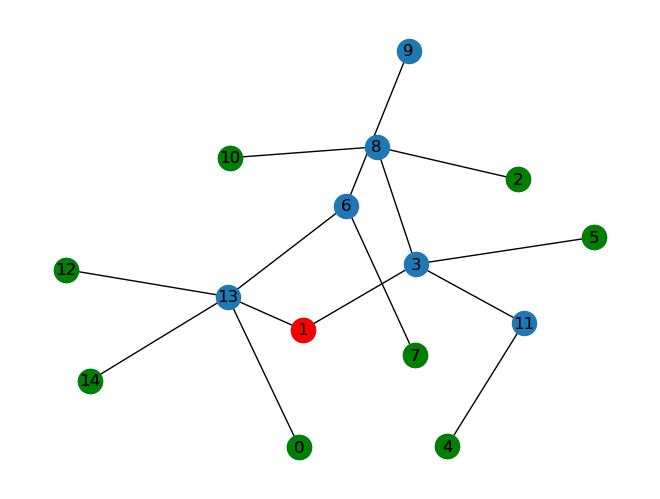

In [28]:
## pay attention to the case when a susceptible node connects 2 or more infected nodes.

s_selected=s_real

gr_bfs=nx.bfs_tree(gr_main.subgraph(gr_nodes_infected), s_selected).to_undirected()
for i in gr_nodes_susceptible:
    if gr_main.degree[i]==1:
        gr_bfs.add_edges_from(gr_main.edges(i))
    else:
        v_cand=sorted([v for (_,v) in gr_main.edges(i)],reverse=True)
        print(gr_main.edges(i),v_cand)
        v_dist_min=np.inf
        v_arg_min=v_cand[0]  # the infected neighbors of i that will be selected by bfs w.r.t s_selected
        for v in v_cand:
            v_dist=nx.shortest_path_length(gr_bfs, s_selected, v)
            if v_dist<=v_dist_min:
                v_arg_min=v
                v_dist_min=v_dist
        gr_bfs.add_edge(i, v)

            
nx.draw(gr_bfs, pos=gnp_pos, with_labels=True)
nx.draw(gr_bfs.subgraph(gr_nodes_susceptible), pos=gnp_pos, node_color='green', with_labels=True)
nx.draw_networkx(gnp.subgraph(s_real), pos=gnp_pos,  node_color='red', with_labels=False)

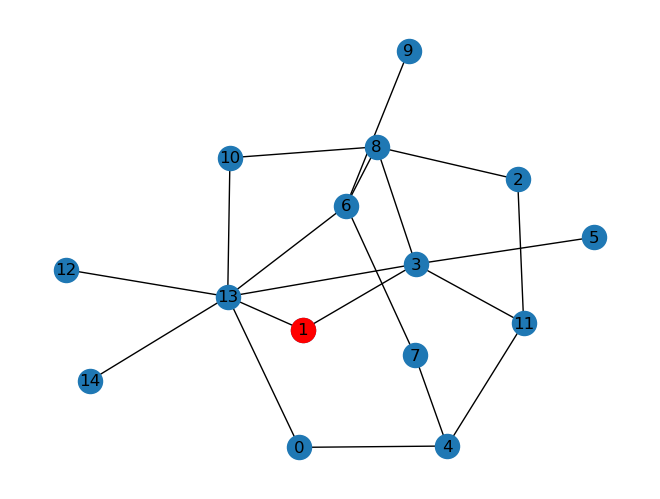

In [29]:
nx.draw(gnp, pos=gnp_pos, with_labels=True)
nx.draw_networkx(gnp.subgraph(s_real), pos=gnp_pos,  node_color='red', with_labels=False)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

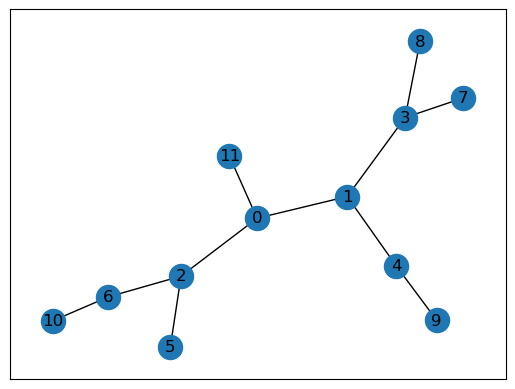

In [281]:
nx.draw_networkx(G)
list(G.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[6, 2, 10, 0, 1, 3, 8, 7, 11, 5, 4, 9] [0, 0.22947727860601222, 0.4799179328356213, 0.6118621424143301, 0.7131530993603956, 1.3204186760856405, 1.4204186760856405, 2.074683435834774, 2.3768695626497713, 2.4090217037752546, 2.603153319177263, 3.1157700350086395]


In [ ]:
gnp_SEED=0

n=15
p=0.6

target_infected_num=7 


def rumor_ER_graph(n,p, target_infected_num, gnp_SEED=0):
    gnp_pass=False
    gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
    gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

    s_real=random.choice(list(gnp.nodes()))

    # gtemp=nx.Graph()
    # gtemp.add_node(s_real)
    # e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # while e_candidate:
    #     gtemp.add_edges_from(e_candidate)
    #     e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # size_s_real_connected = gtemp.size()

    gr=nx.Graph()
    gr.add_node(s_real)
    e_candidate=list(nx.edge_boundary(gnp, gr))

    while gr.size()<target_infected_num-1 and e_candidate:
        e_selected=random.choice(e_candidate)
        gr.add_edge(*e_selected)
        e_candidate=list(nx.edge_boundary(gnp, gr))
        
    if not gr.size()<target_infected_num-1:
        gnp_pass=True
        
    gr_nodes_infected=list(gr.nodes())
    gr_nodes_susceptible=set()
    for e in e_candidate:
        if e[0] in gr_nodes_infected:
            gr_nodes_susceptible.add(e[1])
        else:
            gr_nodes_susceptible.add(e[0])
    gr_nodes_susceptible=list(gr_nodes_susceptible)
    
    return gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected, gr_nodes_susceptible



In [31]:
def rumor_ER_boundary_restriction_graph(n,p, target_infected_num, gnp_SEED=0):
    gnp_pass=False
    gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
    gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

    s_real=random.choice(list(gnp.nodes()))

    gr=nx.Graph()
    gr.add_node(s_real)
    e_candidate=list(nx.edge_boundary(gnp, gr))


    e_forbidden_set = set() # the set of edges whose addition to gr will cause a degree-1 infected node
    while gr.size()<target_infected_num-1 and e_candidate:
        e_selected=random.choice(e_candidate)
        if e_selected[0] in gr:
            new_selected_node = e_selected[1]
        else:
            new_selected_node = e_selected[0]
        if gnp.subgraph(set(gnp.nodes()) - set(gr.nodes())).degree[new_selected_node] == 0:
            e_forbidden_set.add(e_selected)
        gr.add_edge(*e_selected)
        e_candidate=list(set(nx.edge_boundary(gnp, gr)) - e_forbidden_set )
        
    if not gr.size()<target_infected_num-1:
        gnp_pass=True
        
    gr_nodes_infected=list(gr.nodes())
    gr_nodes_susceptible=set()
    for e in e_candidate:
        if e[0] in gr_nodes_infected:
            gr_nodes_susceptible.add(e[1])
        else:
            gr_nodes_susceptible.add(e[0])
    gr_nodes_susceptible=list(gr_nodes_susceptible)
    
    return gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected, gr_nodes_susceptible

In [32]:
def rumor_BA_scale_free_graph(n,p, target_infected_num, gnp_SEED=0):
    gnp_pass=False
    # gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
    gnp=nx.barabasi_albert_graph(n, p,seed=pos_SEED)
    gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

    s_real=random.choice(list(gnp.nodes()))

    # gtemp=nx.Graph()
    # gtemp.add_node(s_real)
    # e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # while e_candidate:
    #     gtemp.add_edges_from(e_candidate)
    #     e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # size_s_real_connected = gtemp.size()

    gr=nx.Graph()
    gr.add_node(s_real)
    e_candidate=list(nx.edge_boundary(gnp, gr))

    while gr.size()<target_infected_num-1 and e_candidate:
        e_selected=random.choice(e_candidate)
        gr.add_edge(*e_selected)
        e_candidate=list(nx.edge_boundary(gnp, gr))
        
    if not gr.size()<target_infected_num-1:
        gnp_pass=True
        
    gr_nodes_infected=list(gr.nodes())
    gr_nodes_susceptible=set()
    for e in e_candidate:
        if e[0] in gr_nodes_infected:
            gr_nodes_susceptible.add(e[1])
        else:
            gr_nodes_susceptible.add(e[0])
    gr_nodes_susceptible=list(gr_nodes_susceptible)
    
    return gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected, gr_nodes_susceptible

In [33]:
def rumor_random_tree_graph(n, target_infected_num, gnp_SEED=0):
    gnp_pass=False
    # gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
    # gnp=nx.barabasi_albert_graph(n, p,seed=pos_SEED)
    ## make the third parameter to be 0.1 by default
    # gnp=nx.watts_strogatz_graph(n,p, p_k, seed=gnp_SEED)

    gnp=nx.random_tree(n, seed=gnp_SEED) # p act as gamma

    gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

    s_real=random.choice(list(gnp.nodes()))

    # gtemp=nx.Graph()
    # gtemp.add_node(s_real)
    # e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # while e_candidate:
    #     gtemp.add_edges_from(e_candidate)
    #     e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # size_s_real_connected = gtemp.size()

    gr=nx.Graph()
    gr.add_node(s_real)
    e_candidate=list(nx.edge_boundary(gnp, gr))

    while gr.size()<target_infected_num-1 and e_candidate:
        e_selected=random.choice(e_candidate)
        gr.add_edge(*e_selected)
        e_candidate=list(nx.edge_boundary(gnp, gr))
        
    if not gr.size()<target_infected_num-1:
        gnp_pass=True
        
    gr_nodes_infected=list(gr.nodes())
    gr_nodes_susceptible=set()
    for e in e_candidate:
        if e[0] in gr_nodes_infected:
            gr_nodes_susceptible.add(e[1])
        else:
            gr_nodes_susceptible.add(e[0])
    gr_nodes_susceptible=list(gr_nodes_susceptible)
    
    return gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected, gr_nodes_susceptible

In [353]:
def extract_gr_main(gnp, gr_nodes_infected, gr_nodes_susceptible):
    ## gr_main is the subgraph of infected and susceptible nodes, with edges between susceptible nodes removed
    gr_main=gnp.subgraph(list(gr_nodes_infected) + list(gr_nodes_susceptible)).copy()
    # remove the edges between susceptible nodes
    for u in gr_nodes_susceptible:
        for v in set(gr_main.neighbors(u)).intersection(gr_nodes_susceptible):
            gr_main.remove_edge(u,v)
    return gr_main

def extract_bfs(gr_main, gr_nodes_infected, gr_nodes_susceptible, s_selected):
    gr_bfs=nx.bfs_tree(gr_main.subgraph(gr_nodes_infected), s_selected).to_undirected()
    for i in gr_nodes_susceptible:
        if gr_main.degree[i]==1:
            gr_bfs.add_edges_from(gr_main.edges(i))
        else:
            v_cand=sorted([v for (_,v) in gr_main.edges(i)],reverse=True)
            # print(gr_main.edges(i),v_cand)
            v_dist_min=np.inf
            v_arg_min=v_cand[0]  # the infected neighbors of i that will be selected by bfs w.r.t s_selected
            for v in v_cand:
                v_dist=nx.shortest_path_length(gr_bfs, s_selected, v)
                if v_dist<=v_dist_min:
                    v_arg_min=v
                    v_dist_min=v_dist
            gr_bfs.add_edge(i, v_arg_min)
    return gr_bfs

In [35]:
def rumor_NW_small_world_graph(n,p, target_infected_num, gnp_SEED=0,p_k=0.1):
    gnp_pass=False
    # gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
    # gnp=nx.barabasi_albert_graph(n, p,seed=pos_SEED)
    ## make the third parameter to be 0.1 by default
    gnp=nx.newman_watts_strogatz_graph(n,p, p_k, seed=gnp_SEED)
    gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

    s_real=random.choice(list(gnp.nodes()))

    # gtemp=nx.Graph()
    # gtemp.add_node(s_real)
    # e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # while e_candidate:
    #     gtemp.add_edges_from(e_candidate)
    #     e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # size_s_real_connected = gtemp.size()

    gr=nx.Graph()
    gr.add_node(s_real)
    e_candidate=list(nx.edge_boundary(gnp, gr))

    while gr.size()<target_infected_num-1 and e_candidate:
        e_selected=random.choice(e_candidate)
        gr.add_edge(*e_selected)
        e_candidate=list(nx.edge_boundary(gnp, gr))
        
    if not gr.size()<target_infected_num-1:
        gnp_pass=True
        
    gr_nodes_infected=list(gr.nodes())
    gr_nodes_susceptible=set()
    for e in e_candidate:
        if e[0] in gr_nodes_infected:
            gr_nodes_susceptible.add(e[1])
        else:
            gr_nodes_susceptible.add(e[0])
    gr_nodes_susceptible=list(gr_nodes_susceptible)
    
    return gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected, gr_nodes_susceptible

In [36]:
def rumor_WS_small_world_graph(n,p, target_infected_num, gnp_SEED=0,p_k=0.1):
    gnp_pass=False
    # gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
    # gnp=nx.barabasi_albert_graph(n, p,seed=pos_SEED)
    ## make the third parameter to be 0.1 by default
    gnp=nx.watts_strogatz_graph(n,p, p_k, seed=gnp_SEED)
    gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

    s_real=random.choice(list(gnp.nodes()))

    # gtemp=nx.Graph()
    # gtemp.add_node(s_real)
    # e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # while e_candidate:
    #     gtemp.add_edges_from(e_candidate)
    #     e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # size_s_real_connected = gtemp.size()

    gr=nx.Graph()
    gr.add_node(s_real)
    e_candidate=list(nx.edge_boundary(gnp, gr))

    while gr.size()<target_infected_num-1 and e_candidate:
        e_selected=random.choice(e_candidate)
        gr.add_edge(*e_selected)
        e_candidate=list(nx.edge_boundary(gnp, gr))
        
    if not gr.size()<target_infected_num-1:
        gnp_pass=True
        
    gr_nodes_infected=list(gr.nodes())
    gr_nodes_susceptible=set()
    for e in e_candidate:
        if e[0] in gr_nodes_infected:
            gr_nodes_susceptible.add(e[1])
        else:
            gr_nodes_susceptible.add(e[0])
    gr_nodes_susceptible=list(gr_nodes_susceptible)
    
    return gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected, gr_nodes_susceptible

In [37]:
def rumor_random_tree_graph(n, target_infected_num, gnp_SEED=0):
    gnp_pass=False
    # gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
    # gnp=nx.barabasi_albert_graph(n, p,seed=pos_SEED)
    ## make the third parameter to be 0.1 by default
    # gnp=nx.watts_strogatz_graph(n,p, p_k, seed=gnp_SEED)

    gnp=nx.random_tree(n, seed=gnp_SEED) # p act as gamma

    gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

    s_real=random.choice(list(gnp.nodes()))

    # gtemp=nx.Graph()
    # gtemp.add_node(s_real)
    # e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # while e_candidate:
    #     gtemp.add_edges_from(e_candidate)
    #     e_candidate=set(nx.edge_boundary(gnp, gtemp))
    # size_s_real_connected = gtemp.size()

    gr=nx.Graph()
    gr.add_node(s_real)
    e_candidate=list(nx.edge_boundary(gnp, gr))

    while gr.size()<target_infected_num-1 and e_candidate:
        e_selected=random.choice(e_candidate)
        gr.add_edge(*e_selected)
        e_candidate=list(nx.edge_boundary(gnp, gr))
        
    if not gr.size()<target_infected_num-1:
        gnp_pass=True
        
    gr_nodes_infected=list(gr.nodes())
    gr_nodes_susceptible=set()
    for e in e_candidate:
        if e[0] in gr_nodes_infected:
            gr_nodes_susceptible.add(e[1])
        else:
            gr_nodes_susceptible.add(e[0])
    gr_nodes_susceptible=list(gr_nodes_susceptible)
    
    return gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected, gr_nodes_susceptible

1
{1} 
 1 4.7475182324904254e-05
0


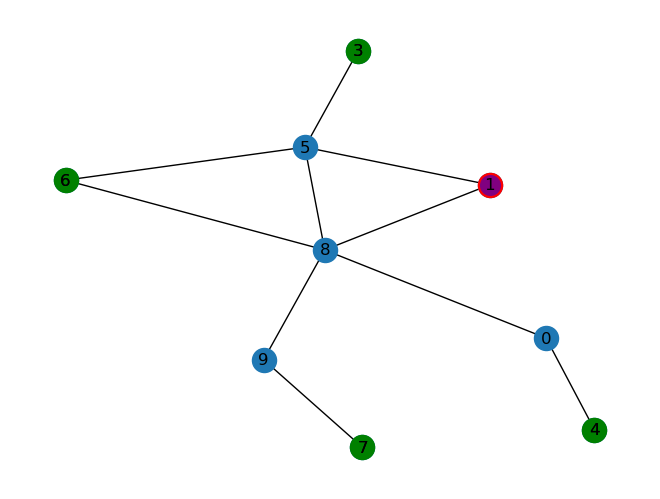

In [84]:
## 由于是先写的零散的代码再整理成函数，并且一开始假设G是tree graph，
## 但是后来需要使用gr_main, 其中会有一个susceptible node 连接多个infected nodes的情况，所以造成有使用nodes_infected 以及gr_nodes_infected变量名的情况
## 另外注意result由于太多小于1的数字相乘变成0的问题，所以添加了dynamic_scale=True 参数

tmax = 100

gnp_SEED=0


n=10
p=0.4

target_infected_num=5



gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected, gr_nodes_susceptible=rumor_ER_graph(n,p, target_infected_num, gnp_SEED=0)

if gnp_pass==True:
    gr_main=extract_gr_main(gnp, gr_nodes_infected, gr_nodes_susceptible)

    result, t_positions=compute_likelihood(tmax=tmax, gr_main=gr_main, gr_nodes_infected=gr_nodes_infected, 
                                           gr_nodes_susceptible=gr_nodes_susceptible, dynamic_scale=True)
    
    max_nodes, max_value=extract_max_nodes(result=result, nodes_infected=gr_nodes_infected)
    
    error_hops=nx.shortest_path_length(gr_main, s_real, list(max_nodes)[0])
      
      
print(s_real)
print(max_nodes, '\n', len(max_nodes),max_value)
print(error_hops)

nx.draw(gr_main, pos=gnp_pos, with_labels=True)
nx.draw(gr_main.subgraph(gr_nodes_susceptible), pos=gnp_pos, node_color='green', with_labels=True)
nx.draw_networkx(gnp.subgraph(s_real), pos=gnp_pos,  node_color='red', with_labels=False)
nx.draw_networkx(gnp.subgraph(max_nodes), pos=gnp_pos,  node_color='purple', node_size=200 , with_labels=False)


In [39]:
# result

In [146]:
#### https://github.com/networkx/networkx/pull/6903/files
def rumor_centrality(G):
    """Compute the rumor centrality for nodes.
    Parameters
    ----------
    G : graph
      A networkx graph
    Returns
    -------
    nodes : dictionary
       Dictionary of nodes with degree centrality as the value.
    Raises
    ------
    NetworkXPointlessConcept
        If the graph G is the null graph.
    Notes
    -----
    Rumor centrality was introduced by Shah & Zaman [1]_ for rumor source detection.
    .. [1] Shah, Devavrat, and Tauhid Zaman. "Rumor centrality: a universal source detector." In Proceedings of the
    12th ACM SIGMETRICS/PERFORMANCE joint international conference on Measurement and Modeling of Computer Systems,
    pp. 199-210. 2012.
    """

    if len(G) == 0:
        raise nx.NetworkXPointlessConcept(
            "cannot compute centrality for the null graph"
        )

    # Create copy to be able to use node properties
    H = G.copy()
    set_visited_to_false(H)

    # Calculate rumor centrality for a single vertex
    arbitrary_start_vertex = list(H)[0]
    calculate_rumor_centrality_for_single_vertex(
        H, arbitrary_start_vertex, arbitrary_start_vertex
    )

    # Calculate rumor centrality for remaining vertices
    set_visited_to_false(H)
    H.nodes[arbitrary_start_vertex]["visited"] = True
    for neighbor in H.neighbors(arbitrary_start_vertex):
        calculate_for_remaining(
            H, neighbor, H.nodes[arbitrary_start_vertex]["rumor_centrality"]
        )

    print({v:{ H.nodes[v]["subtree_size"], H.nodes[v]["cumulative_prod"]} for v in H.nodes} )
    return {v: H.nodes[v]["rumor_centrality"] for v in H.nodes}


def calculate_rumor_centrality_for_single_vertex(G, v, start_vertex):
    # Mark v as visited
    G.nodes[v]["visited"] = True

    # Collect all unvisited neighbors
    unvisited_neighbors = []
    for neighbor in G.neighbors(v):
        if not G.nodes[neighbor]["visited"]:
            unvisited_neighbors.append(neighbor)

    # If v does not have unvisited neighbors, initialize v with default values
    if len(unvisited_neighbors) == 0:
        G.nodes[v]["subtree_size"] = 1
        G.nodes[v]["cumulative_prod"] = 1
        return 1, 1

    # If v has unvisited neighbors, invoke recursive call for each of them
    # and calculate cumulative sum and product
    cum_sum, cum_prod = 0, 1
    for neighbor in unvisited_neighbors:
        a, b = calculate_rumor_centrality_for_single_vertex(G, neighbor, start_vertex)
        cum_sum += a
        cum_prod *= b

    # Calculate rumor centrality for chosen root
    if v == start_vertex:
        G.nodes[v]["rumor_centrality"] = math.factorial(len(G) - 1) // cum_prod

    # Calculate v's values
    G.nodes[v]["subtree_size"] = cum_sum + 1
    G.nodes[v]["cumulative_prod"] = cum_prod * G.nodes[v]["subtree_size"]

    # Return v's values
    # print('v, G.nodes[v]["subtree_size"]', v, G.nodes[v]["subtree_size"])
    return G.nodes[v]["subtree_size"], G.nodes[v]["cumulative_prod"]


def set_visited_to_false(G):
    for node in G.nodes:
        G.nodes[node]["visited"] = False


def calculate_for_remaining(G, vertex, parent_rumor_centrality):
    G.nodes[vertex]["visited"] = True
    # print(len(G),vertex,G.nodes[vertex]["subtree_size"])
    G.nodes[vertex]["rumor_centrality"] = int(
        parent_rumor_centrality
        * G.nodes[vertex]["subtree_size"]
        / (len(G) - G.nodes[vertex]["subtree_size"])
    )

    for neighbor in G.neighbors(vertex):
        if not G.nodes[neighbor]["visited"]:
            calculate_for_remaining(G, neighbor, G.nodes[vertex]["rumor_centrality"])

In [226]:


def compute_ml_by_rumor_centrality(gr_main=gr_main, gr_nodes_infected=gr_nodes_infected):
    reciprocal_ml_set={}
    for s in gr_nodes_infected:
        gr_nodes_infected_bfs_tree=nx.bfs_tree(gr_main.subgraph(gr_nodes_infected), s).to_undirected()
        psigmas_numerator=1
        s_set={s}
        for e in gr_nodes_infected_bfs_tree.edges():
            psigmas_numerator*=len(list(nx.edge_boundary(gr_main, s_set)))
            s_set.add(e[1])

        H = gr_nodes_infected_bfs_tree.copy()
        set_visited_to_false(H)
        calculate_rumor_centrality_for_single_vertex(H, s, s)
        # s_rumor_centrality=math.factorial(H.nodes[s]["subtree_size"]) // H.nodes[s]["cumulative_prod"]
        reciprocal_s_ml_by_rumor_centrality = (H.nodes[s]["cumulative_prod"] * psigmas_numerator) // math.factorial(H.nodes[s]["subtree_size"]) 
        # s_ml_by_rumor_centrality = 1 / reciprocal_s_ml_by_rumor_centrality
        reciprocal_ml_set[s]=reciprocal_s_ml_by_rumor_centrality

    return reciprocal_ml_set



In [225]:
# print(gr_nodes_infected)

[36, 42, 15, 0, 45, 39, 48, 33, 41, 11]


In [228]:
# reciprocal_ml_set=compute_ml_by_rumor_centrality(gr_main,bfs_nodes_infected)
# print(reciprocal_ml_set)

{36: 4321, 0: 10590, 42: 62208, 45: 5295, 41: 62222, 11: 839808, 15: 241521, 48: 32659, 39: 228243, 33: 1917248}


In [218]:
# rumor_centrality(bfs_nodes_infected)

{36: {960, 10}, 0: {24, 4}, 42: {4}, 45: {1}, 41: {3, 6}, 11: {1}, 15: {1}, 48: {1}, 39: {2}, 33: {1}}


{36: 3780,
 0: 2520,
 42: 2520,
 45: 420,
 41: 1080,
 11: 280,
 15: 280,
 48: 280,
 39: 270,
 33: 30}

[(36, 0), (36, 42), (36, 45), (0, 41), (42, 11), (42, 15), (42, 48), (41, 39), (39, 33)]


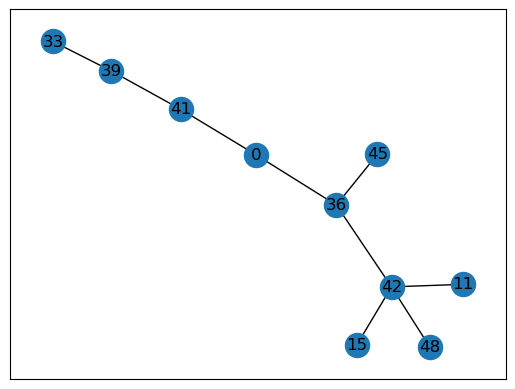

In [211]:
# # nx.draw(gr_main)
# bfs_nodes_infected=nx.bfs_tree(gr_main.subgraph(gr_nodes_infected), list(gr_nodes_infected)[0]).to_undirected()
# print(list(bfs_nodes_infected.edges()))
# nx.draw_networkx(bfs_nodes_infected)


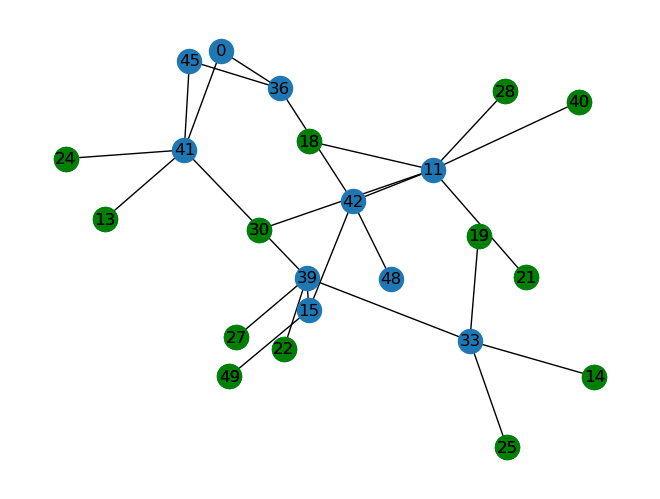

In [229]:
# nx.draw(gr_main, pos=gnp_pos, with_labels=True)
# nx.draw(gr_main.subgraph(gr_nodes_susceptible), pos=gnp_pos, node_color='green', with_labels=True)

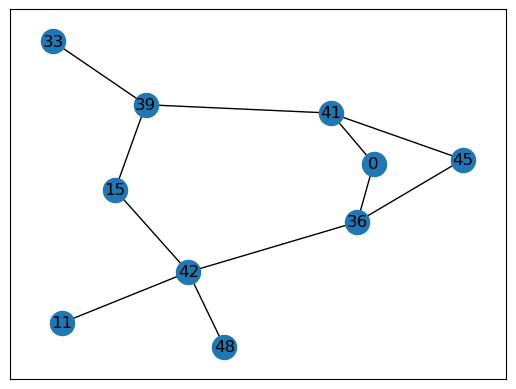

In [231]:
# nx.draw_networkx(gr_main.subgraph(gr_nodes_infected))

In [557]:

s_real=None
final_infected_num=None
final_t=np.inf


gnp_pass=False
gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

def continuous_time_simulation(gnp, final_t=np.inf, t_unit=0.01,s_real=None, final_infected_num=None):
    # print("continuous_time_simulation called")


    t_unit=0.1

    t=0

    gnp=nx.Graph(gnp)

    # print(list(gnp.nodes()))


    for e in gnp.edges():
        gnp.edges[*e]["spreading_time"]=np.inf

    for n in gnp.nodes():
        gnp.nodes[n]["when_infected"]=np.inf

    if s_real==None:
        s_real=random.choice(list(gnp.nodes()))


    if final_infected_num==None:
        final_infected_num=len(nx.node_connected_component(gnp, s_real))

    gnp_pass=True
    if final_infected_num>len(nx.node_connected_component(gnp, s_real)):
        gnp_pass=False
        gr_infection_order_list=[]
        gr_infection_time_list=[]
    else:

        gnp.nodes[s_real]["when_infected"]=0

        gr_nodes_infected=set()
        gr_nodes_susceptible=set()

        gr_nodes_infected.add(s_real)

        for v in gnp.adj[s_real]:
            gr_nodes_susceptible.add(v)
            gnp[s_real][v]["spreading_time"]=max(np.random.exponential(), t_unit)
            gnp.nodes[v]["when_infected"]=gnp[s_real][v]["spreading_time"]


        while len(gr_nodes_infected)<final_infected_num and t<final_t:
            # print(len(gr_nodes_infected), final_infected_num, t)
            t+=t_unit
            for u in gr_nodes_susceptible.copy():
                if gnp.nodes[u]["when_infected"]<=t:
                    gr_nodes_infected.add(u)
                    gr_nodes_susceptible.remove(u)
                    for v in gnp.adj[u]:
                        if gnp.nodes[v]["when_infected"]==np.inf:
                            gnp[u][v]["spreading_time"]=max(np.random.exponential(), t_unit)
                            gnp.nodes[v]["when_infected"]=min(gnp.nodes[v]["when_infected"], gnp.nodes[u]["when_infected"]+gnp[u][v]["spreading_time"])         
                            gr_nodes_susceptible.add(v)

        gr_infection_order_list=[]
        gr_infection_time_list=[]

        for k, v in sorted(dict(gnp.subgraph(gr_nodes_infected).nodes(data="when_infected")).items(), key=lambda item: item[1]):
            gr_infection_order_list.append(k)
            gr_infection_time_list.append(v)

    # print("continuous_time_simulation finished")
    
    return gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list

gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list = continuous_time_simulation(gnp, final_t=np.inf, t_unit=0.01,s_real=None, final_infected_num=None)
print(gnp_pass,gr_infection_order_list, gr_infection_time_list)






True [36, 42, 45, 41, 15, 39, 33, 19, 27, 11, 18, 5, 48, 21, 22, 23, 24, 49, 28, 29, 13, 8, 0, 3, 14, 2, 32, 35, 26, 40, 9, 31, 37, 43, 47, 4, 30, 34, 16, 12, 25, 38, 6, 46, 7] [0, 0.2706158826601115, 0.6138221068933808, 0.7976928288783622, 0.9412820036515789, 1.0318564264205945, 1.2038671201120037, 1.3038671201120038, 1.4393740233770225, 1.4716170210849076, 1.6140068387643798, 1.6583634880276095, 1.695592541708061, 1.8042643797958762, 1.8239078473252208, 1.915756288390365, 2.1047258136353713, 2.163219210118061, 2.1697415884057705, 2.1751740230591103, 2.1807895615535173, 2.19633507807876, 2.266717756694641, 2.2751740230591104, 2.369219568601519, 2.3855492648646344, 2.714233044882937, 2.8910129249368866, 2.9084366267870028, 2.947317822300449, 3.0273933520300877, 3.1761483654880402, 3.235288665031395, 3.307983995321199, 3.504980603501357, 3.7183034166431077, 3.793109592392616, 3.8352624488849036, 4.031423588357274, 4.171502525617772, 4.2189213296793575, 4.649920681204181, 4.7499206812041

In [627]:
SIMULATION_TYPE=None
SIMULATION_TYPE='continous_time'

gnp_SEED=0

GRAPH_TYPE="ER"
graph_type_to_test=["ER"]
# graph_type_to_test=["ER", "random_tree","random_regular_graph"}]

CENTRALITY_TYPE='pseudo_leaf'
# centrality_type_to_test=['pseudo_leaf']
centrality_type_to_test=['pseudo_leaf', 'rumor_centrality', 'closeness_centrality']

tmax=25


n_list=[50,100,150,200,250,300]
p_list=[0.04]

# er_n=n_list[0]
# er_p=p_list[0]

# s_real=None

# gnp_pass=False
# gnp_fail_count=0

repeat_num=500

all_results={}


# target_infected_ratio_list=[0.01, 0.02, 0.03]
# target_infected_ratio_list=[0.04, 0.08, 0.12]
target_infected_ratio_list=[0.1,0.2,0.3]



if SIMULATION_TYPE=='continous_time':
    for GRAPH_TYPE in graph_type_to_test:
        all_results[GRAPH_TYPE]={}
        for CENTRALITY_TYPE in centrality_type_to_test: 
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]={}

            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]=np.full([len(n_list), len(p_list), len(target_infected_ratio_list), repeat_num], np.nan)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["pairwise_average_dist_list"]=np.full([len(n_list), len(p_list), len(target_infected_ratio_list), repeat_num], np.nan)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_pass_count"]=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_fail_count"]=np.zeros([len(n_list), len(p_list)])
            # recorded_count=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["recorded_count"]=np.zeros([len(n_list), len(p_list)])
            # gnp_fail_count=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["max_nodes_multiple_count"]=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])       




for n_index in range(len(n_list)):
    n=n_list[n_index]
    final_infected_num=n*target_infected_ratio_list[-1]
    print("current n:",n, '\n', "current time:", datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'))
    for p_index in range(len(p_list)):
        if GRAPH_TYPE=='ER':
            p=p_list[p_index]
        elif GRAPH_TYPE=="BA_scale_free":
            # use p as the number of nodes for initiallization
            p=int(n*p_list[p_index])
        elif GRAPH_TYPE=="NW_small_world":
            # p indeed is the argument for k
            p=int(n*p_list[p_index])+1
        elif GRAPH_TYPE=="WS_small_world":
            # p indeed is the argument for k
            p=int(n*p_list[p_index])+1
        elif GRAPH_TYPE=="random_tree":
            p=0
        else:
            print("wrong GRAPH_TYPE")

        if SIMULATION_TYPE=='continous_time':
            for GRAPH_TYPE in graph_type_to_test:
                print('n: ', n, 'p' ,p, 'GRAPH_TYPE: ', GRAPH_TYPE,'SIMULATION_TYPE: ',SIMULATION_TYPE)
                repeat_index=0
                while all_results[GRAPH_TYPE][CENTRALITY_TYPE]["recorded_count"][n_index][p_index]<repeat_num:
                    # print('repeat_index', repeat_index)
                    gnp_pass=False  
                    while gnp_pass==False and all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_fail_count"][n_index][p_index]<2*repeat_num:
                        if GRAPH_TYPE=='ER':
                            # gnp=nx.gnp_random_graph(n=er_n, p=er_p, seed=gnp_SEED, directed=False)
                            gnp=nx.gnp_random_graph(n=n, p=p, seed=gnp_SEED, directed=False)
                            # print('new gnp generated')
                        else:
                            print("wrong GRAPH_TYPE")                                
                        gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)
                        gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list = continuous_time_simulation(gnp, final_t=np.inf, t_unit=0.01,s_real=None, final_infected_num=final_infected_num)

                        if gnp_pass==False:
                            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_fail_count"][n_index][p_index]+=1
                    if gnp_pass==False:
                        print('generation failed with ', 'er_n:', er_n, 'er_p', er_p)
                        all_results[GRAPH_TYPE][CENTRALITY_TYPE]["recorded_count"][n_index][p_index]+=1
                    else:
                        for t_i_r_index in range(len(target_infected_ratio_list)):
                            # print("current t_i_r_index:",t_i_r_index, '\n', "current time:", datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'))    
                            target_infected_num=math.ceil(n_list[n_index]*target_infected_ratio_list[t_i_r_index])
                            gr_nodes_infected=gr_infection_order_list[0:target_infected_num]
                            gr_nodes_susceptible=nx.node_boundary(gnp, gr_nodes_infected)
                            # nx.draw_networkx(gnp)
                            # print(gr_infection_order_list, gr_infection_time_list)


                            # if GRAPH_TYPE=="BA_scale_free":
                            #     gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_BA_scale_free_graph(n,p, target_infected_num, gnp_SEED=0)
                            # elif GRAPH_TYPE=="NW_small_world":
                            #     # p_k is in fact the k parameter for generating NW_small_world graph
                            #     gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_NW_small_world_graph(n,p, target_infected_num, gnp_SEED=0,p_k=0.1)
                            # elif GRAPH_TYPE=="WS_small_world":
                            #     # p_k is in fact the k parameter for generating NW_small_world graph
                            #     gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_WS_small_world_graph(n,p, target_infected_num, gnp_SEED=0,p_k=0.1)
                            # elif GRAPH_TYPE=="random_tree":
                            #     gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_random_tree_graph(n, target_infected_num, gnp_SEED=0)
                            # elif GRAPH_TYPE=="ER_boundary_restriction": 
                            #     gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_ER_boundary_restriction_graph(n,p, target_infected_num, gnp_SEED=0)
                            # else:
                            #     gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_ER_graph(n,p, target_infected_num, gnp_SEED=0)


                            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_pass_count"][n_index][p_index][t_i_r_index]+=1
                            gr_main=extract_gr_main(gnp, gr_nodes_infected, gr_nodes_susceptible)

                            for CENTRALITY_TYPE in centrality_type_to_test:
                                if CENTRALITY_TYPE=='pseudo_leaf':
                                    # nx.draw_networkx(gr_main)
                                    # print("gr_nodes_infected, gr_nodes_susceptible",gr_nodes_infected, gr_nodes_susceptible)
                                    result, t_positions=compute_likelihood(tmax=tmax, gr_main=gr_main, gr_nodes_infected=gr_nodes_infected, 
                                    gr_nodes_susceptible=gr_nodes_susceptible,tcount=51, dynamic_scale=True)
                                    max_nodes, max_value=extract_max_nodes(result=result, nodes_infected=gr_nodes_infected)
                                elif CENTRALITY_TYPE=='Jordan center':
                                    result_jordan=dict(nx.eccentricity(gnp.subgraph(gr_nodes_infected)))
                                    result={k:1/v for k,v in result_jordan.items()}
                                    max_value=max(result.values())
                                    max_nodes=[i for i in gr_nodes_infected if result[i]==max_value]
                                    # tmax=None
                                    # print(result, len(max_nodes))
                                elif CENTRALITY_TYPE=='closeness_centrality':
                                    result=dict(nx.closeness_centrality(gnp.subgraph(gr_nodes_infected)))
                                    max_value=max(result.values())
                                    max_nodes=[i for i in gr_nodes_infected if result[i]==max_value]
                                    # tmax=None
                                elif CENTRALITY_TYPE=='rumor_centrality':
                                    reciprocal_ml_set=compute_ml_by_rumor_centrality(gr_main=gr_main, gr_nodes_infected=gr_nodes_infected)
                                    min_value=min(reciprocal_ml_set.values())
                                    max_nodes=[i for i in gr_nodes_infected if reciprocal_ml_set[i]==min_value]
                                    max_value=1/min_value
                                    result=reciprocal_ml_set
                                    # tmax=None                        
                                
                                error_hops=nx.shortest_path_length(gr_main, s_real, list(max_nodes)[0])
                                # print('error_hops, s_real, max_nodes[0],max_value', error_hops, s_real, list(max_nodes)[0], max_value)
                                
                                if len(max_nodes)==1:
                                    all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"][n_index][p_index][t_i_r_index][repeat_index]=error_hops
                                    all_results[GRAPH_TYPE][CENTRALITY_TYPE]["pairwise_average_dist_list"][n_index][p_index][t_i_r_index][repeat_index]=nx.average_shortest_path_length(gr_main.subgraph(gr_nodes_infected))
                                else:
                                    # error_hops_list[n_index][p_index][t_i_r_index][repeat_index]=np.nan
                                    # pairwise_average_dist_list[n_index][p_index][t_i_r_index][repeat_index]=np.nan
                                    all_results[GRAPH_TYPE][CENTRALITY_TYPE]["max_nodes_multiple_count"][n_index][p_index][t_i_r_index]+=1
                            # only let the case when there are multiple predicted source to be np.nan
                    
                    all_results[GRAPH_TYPE][CENTRALITY_TYPE]["recorded_count"][n_index][p_index]+=1
                    repeat_index+=1


# print(all_results)

if SIMULATION_TYPE=='continous_time':
    for GRAPH_TYPE in graph_type_to_test:
        for CENTRALITY_TYPE in centrality_type_to_test: 
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["zero_error_rate"]=1-(np.count_nonzero(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"],axis=3)-np.count_nonzero(np.isnan(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]), axis=3))/(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"].shape[3]-np.count_nonzero(np.isnan(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]), axis=3))
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["ave_error_hops_list"]=np.nanmean(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"], axis=3)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["ave_pairwise_average_dist_list"]=np.nanmean(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["pairwise_average_dist_list"], axis=3)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["one_hop_error_rate"]= all_results[GRAPH_TYPE][CENTRALITY_TYPE]["zero_error_rate"] + 1-(np.count_nonzero(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]-1,axis=3)-np.count_nonzero(np.isnan(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]), axis=3))/(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"].shape[3]-np.count_nonzero(np.isnan(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]), axis=3))
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["std_error_hops_list"]=np.round(np.sqrt(np.nanvar(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"], axis=3, ddof=1)),3)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["std_pairwise_average_dist_list"]=np.round(np.sqrt(np.nanvar(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["pairwise_average_dist_list"], axis=3, ddof=1)),3)

if repeat_num>20:
    time_str=datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d%H%M%S')
    file_name='rumor_vars_'+time_str+'.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump([all_results, graph_type_to_test, centrality_type_to_test, tmax, 
                    n_list,p_list,target_infected_ratio_list,repeat_num], f)







current n: 50 
 current time: 231012 01:52:41
n:  50 p 0.04 GRAPH_TYPE:  ER SIMULATION_TYPE:  continous_time
current n: 100 
 current time: 231012 02:00:07
n:  100 p 0.04 GRAPH_TYPE:  ER SIMULATION_TYPE:  continous_time
current n: 150 
 current time: 231012 02:42:23
n:  150 p 0.04 GRAPH_TYPE:  ER SIMULATION_TYPE:  continous_time
current n: 200 
 current time: 231012 04:43:43
n:  200 p 0.04 GRAPH_TYPE:  ER SIMULATION_TYPE:  continous_time
current n: 250 
 current time: 231012 08:56:10
n:  250 p 0.04 GRAPH_TYPE:  ER SIMULATION_TYPE:  continous_time
current n: 300 
 current time: 231012 16:16:48
n:  300 p 0.04 GRAPH_TYPE:  ER SIMULATION_TYPE:  continous_time


In [629]:
print("end time:", datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'))

end time: 231013 03:44:42


In [630]:
np.count_nonzero(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"],axis=3)
all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]

array([[[[ 0.,  1.,  1., ...,  1.,  1.,  0.],
         [ 0., nan,  1., ..., nan,  1.,  0.],
         [ 1.,  2.,  2., ...,  1.,  2.,  0.]]],


       [[[ 0., nan, nan, ..., nan,  1., nan],
         [ 0.,  0.,  2., ...,  3.,  1., nan],
         [ 0.,  2.,  2., ...,  3.,  1.,  1.]]],


       [[[ 1.,  2.,  1., ...,  0.,  2.,  1.],
         [ 2.,  2.,  1., ...,  2.,  2.,  1.],
         [ 2.,  2.,  2., ...,  2.,  3., nan]]],


       [[[ 0.,  2.,  2., ...,  0.,  1.,  1.],
         [ 0., nan,  1., ...,  1.,  1.,  1.],
         [ 0.,  1.,  1., ...,  2.,  2., nan]]],


       [[[ 1.,  2.,  0., ...,  1.,  0.,  1.],
         [ 2.,  1.,  0., ...,  1.,  0.,  2.],
         [ 2.,  1.,  0., ...,  3.,  0.,  2.]]],


       [[[ 0.,  1.,  1., ...,  0.,  1.,  0.],
         [ 0.,  1.,  1., ...,  0.,  1.,  2.],
         [ 0.,  2.,  1., ...,  2.,  1.,  2.]]]])

In [631]:
if SIMULATION_TYPE=='continous_time':
    for GRAPH_TYPE in graph_type_to_test:
        for CENTRALITY_TYPE in centrality_type_to_test: 
            print('\n',GRAPH_TYPE, CENTRALITY_TYPE)
            print(np.squeeze(np.round(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["zero_error_rate"],2), axis=1),
                  np.squeeze(np.round(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["ave_error_hops_list"],2), axis=1),
                  np.squeeze(np.round(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["ave_pairwise_average_dist_list"],2), axis=1),
                  np.squeeze(np.round(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["one_hop_error_rate"],2), axis=1),
                  np.squeeze(np.round(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["std_error_hops_list"],2), axis=1),
                  np.squeeze(np.round(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["std_pairwise_average_dist_list"],2), axis=1), sep='\n\n')



 ER pseudo_leaf
[[0.27 0.23 0.18]
 [0.3  0.2  0.18]
 [0.29 0.24 0.16]
 [0.36 0.23 0.18]
 [0.3  0.2  0.13]
 [0.37 0.18 0.11]]

[[0.87 1.19 1.4 ]
 [1.02 1.34 1.51]
 [0.93 1.19 1.47]
 [0.84 1.22 1.46]
 [0.93 1.27 1.62]
 [0.86 1.34 1.66]]

[[1.82 2.66 3.16]
 [2.58 3.24 3.46]
 [2.9  3.37 3.42]
 [3.07 3.39 3.34]
 [3.19 3.37 3.28]
 [3.21 3.3  3.17]]

[[0.86 0.65 0.6 ]
 [0.72 0.59 0.53]
 [0.81 0.66 0.55]
 [0.82 0.64 0.52]
 [0.79 0.61 0.44]
 [0.79 0.55 0.39]]

[[0.63 0.86 1.03]
 [0.84 0.96 1.06]
 [0.75 0.9  1.  ]
 [0.77 0.91 0.98]
 [0.76 0.87 0.94]
 [0.81 0.87 0.89]]

[[0.13 0.25 0.31]
 [0.25 0.32 0.3 ]
 [0.28 0.28 0.23]
 [0.27 0.22 0.16]
 [0.26 0.18 0.13]
 [0.23 0.16 0.11]]

 ER rumor_centrality
[[0.38 0.23 0.16]
 [0.33 0.22 0.15]
 [0.33 0.24 0.15]
 [0.33 0.21 0.15]
 [0.31 0.22 0.16]
 [0.38 0.23 0.12]]

[[0.84 1.18 1.54]
 [1.03 1.44 1.7 ]
 [0.96 1.29 1.57]
 [0.95 1.32 1.52]
 [0.93 1.27 1.58]
 [0.84 1.27 1.64]]

[[1.83 2.67 3.16]
 [2.58 3.24 3.46]
 [2.9  3.37 3.42]
 [3.07 3.39 3.34]
 [3.19 3.3

In [ ]:
---------------------------------------------

GRAPH_TYPE:  None CENTRALITY_TYPE:  None
start time: 231007 01:02:37
current n: 50 
 current time: 231007 01:02:37
current n: 100 
 current time: 231007 01:19:39
current n: 150 
 current time: 231007 02:55:39
current n: 200 
 current time: 231007 07:14:20
current n: 250 
 current time: 231007 15:48:34
current n: 300 
 current time: 231008 06:02:46
error_hops_list
 [[[[1. 2. 1. ... 1. 1. 1.]]

  [[0. 0. 0. ... 0. 0. 2.]]

  [[0. 2. 2. ... 2. 1. 1.]]

  [[1. 1. 0. ... 1. 1. 0.]]

  [[2. 1. 1. ... 2. 2. 1.]]]


 [[[3. 1. 1. ... 0. 3. 3.]]

  [[2. 3. 1. ... 2. 2. 1.]]

  [[1. 2. 2. ... 0. 1. 2.]]

  [[1. 2. 1. ... 1. 2. 2.]]

  [[2. 2. 1. ... 1. 2. 1.]]]


 [[[1. 2. 0. ... 1. 1. 1.]]

  [[0. 1. 2. ... 2. 0. 3.]]

  [[1. 2. 1. ... 2. 2. 2.]]

  [[1. 0. 2. ... 2. 1. 1.]]

  [[2. 1. 1. ... 2. 2. 2.]]]


 [[[1. 0. 1. ... 0. 2. 2.]]

  [[2. 2. 2. ... 2. 1. 1.]]

  [[2. 1. 2. ... 1. 2. 2.]]

  [[2. 2. 2. ... 1. 1. 2.]]

  [[2. 1. 2. ... 1. 1. 2.]]]


 [[[1. 2. 0. ... 2. 3. 2.]]

  [[2. 2. 2. ...

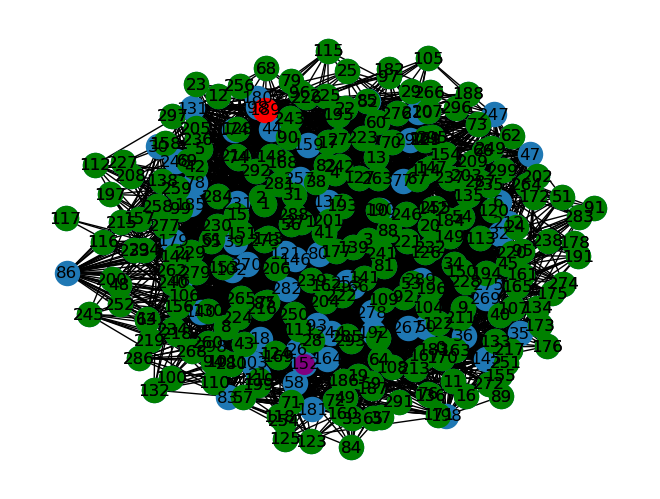

In [249]:
## benchmark

tmax = 25
gnp_SEED=0

CENTRALITY_TYPE=None

# CENTRALITY_TYPE='Jordan center'
# CENTRALITY_TYPE='closeness_centrality'
# CENTRALITY_TYPE='rumor_centrality'

GRAPH_TYPE=None
# GRAPH_TYPE="ER_boundary_restriction"
# GRAPH_TYPE="BA_scale_free"
# GRAPH_TYPE="NW_small_world"
# GRAPH_TYPE="WS_small_world"
# GRAPH_TYPE="random_tree"

n_list=[50,100,150,200,250,300]
# p_list=[0.05, 0.1,0.2,0.3,0.4]
p_list=[0.02, 0.04,0.06,0.08,0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
# p_list=[0.02, 0.04,0.06,0.08,0.1, 0.15, 0.2]

p_list=[0.04,0.08,0.12]
p_list=[0.04,0.08,0.12,0.16,0.2]


if GRAPH_TYPE=="random_tree":
    p_list=[1]



target_infected_ratio_list=[0.2]


repeat_num=100
repeat_num=500

print('GRAPH_TYPE: ', GRAPH_TYPE, 'CENTRALITY_TYPE: ', CENTRALITY_TYPE)
print("start time:", datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'))


error_hops_list=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list), repeat_num])

pairwise_average_dist_list=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list), repeat_num])

gnp_pass_count=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
recorded_count=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
gnp_fail_count=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
max_nodes_multiple_count=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])

for n_index in range(len(n_list)):
    n=n_list[n_index]
    print("current n:",n, '\n', "current time:", datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'))
    for p_index in range(len(p_list)):
        if GRAPH_TYPE=="BA_scale_free":
            # use p as the number of nodes for initiallization
            p=int(n*p_list[p_index])
        elif GRAPH_TYPE=="NW_small_world":
            # p indeed is the argument for k
            p=int(n*p_list[p_index])+1
        elif GRAPH_TYPE=="WS_small_world":
            # p indeed is the argument for k
            p=int(n*p_list[p_index])+1
        elif GRAPH_TYPE=="random_tree":
            p=0
        else:
            p=p_list[p_index]

        for t_i_r_index in range(len(target_infected_ratio_list)):
            target_infected_num=n_list[n_index]*target_infected_ratio_list[t_i_r_index]
            repeat_index=0
            while recorded_count[n_index][p_index][t_i_r_index]<repeat_num:
                if GRAPH_TYPE=="BA_scale_free":
                    gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_BA_scale_free_graph(n,p, target_infected_num, gnp_SEED=0)
                elif GRAPH_TYPE=="NW_small_world":
                    # p_k is in fact the k parameter for generating NW_small_world graph
                    gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_NW_small_world_graph(n,p, target_infected_num, gnp_SEED=0,p_k=0.1)
                elif GRAPH_TYPE=="WS_small_world":
                    # p_k is in fact the k parameter for generating NW_small_world graph
                    gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_WS_small_world_graph(n,p, target_infected_num, gnp_SEED=0,p_k=0.1)
                elif GRAPH_TYPE=="random_tree":
                    gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_random_tree_graph(n, target_infected_num, gnp_SEED=0)
                elif GRAPH_TYPE=="ER_boundary_restriction": 
                    gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_ER_boundary_restriction_graph(n,p, target_infected_num, gnp_SEED=0)
                else:
                    gnp_pass, gnp, gnp_pos, s_real, gr_nodes_infected,gr_nodes_susceptible=rumor_ER_graph(n,p, target_infected_num, gnp_SEED=0)

                if gnp_pass==True:
                    gnp_pass_count[n_index][p_index][t_i_r_index]+=1
                    gr_main=extract_gr_main(gnp, gr_nodes_infected, gr_nodes_susceptible)

                    if CENTRALITY_TYPE=='Jordan center':
                        result_jordan=dict(nx.eccentricity(gnp.subgraph(gr_nodes_infected)))
                        result={k:1/v for k,v in result_jordan.items()}
                        max_value=max(result.values())
                        max_nodes=[i for i in gr_nodes_infected if result[i]==max_value]
                        tmax=None
                        # print(result, len(max_nodes))
                    elif CENTRALITY_TYPE=='closeness_centrality':
                        result=dict(nx.closeness_centrality(gnp.subgraph(gr_nodes_infected)))
                        max_value=max(result.values())
                        max_nodes=[i for i in gr_nodes_infected if result[i]==max_value]
                        tmax=None
                    elif CENTRALITY_TYPE=='rumor_centrality':
                        reciprocal_ml_set=compute_ml_by_rumor_centrality(gr_main=gr_main, gr_nodes_infected=gr_nodes_infected)
                        min_value=min(reciprocal_ml_set.values())
                        max_nodes=[i for i in gr_nodes_infected if reciprocal_ml_set[i]==min_value]
                        max_value=1/min_value
                        result=reciprocal_ml_set
                        tmax=None                        
                    else:
                        result, t_positions=compute_likelihood(tmax=tmax, gr_main=gr_main, gr_nodes_infected=gr_nodes_infected, 
                        gr_nodes_susceptible=gr_nodes_susceptible,tcount=51, dynamic_scale=True)
                        max_nodes, max_value=extract_max_nodes(result=result, nodes_infected=gr_nodes_infected)
                    
                    error_hops=nx.shortest_path_length(gr_main, s_real, list(max_nodes)[0])
                    
                    if len(max_nodes)==1:
                        error_hops_list[n_index][p_index][t_i_r_index][repeat_index]=error_hops
                        pairwise_average_dist_list[n_index][p_index][t_i_r_index][repeat_index]=nx.average_shortest_path_length(gr_main.subgraph(gr_nodes_infected))
                        repeat_index+=1
                        recorded_count[n_index][p_index][t_i_r_index]+=1
                    else:
                        max_nodes_multiple_count[n_index][p_index][t_i_r_index]+=1
                else:
                    gnp_fail_count[n_index][p_index][t_i_r_index]+=1

                if gnp_fail_count[n_index][p_index][t_i_r_index]+gnp_pass_count[n_index][p_index][t_i_r_index]>2*repeat_num:
                    print("too many failed attempt for n, p, target_infected_ratio ", n, p, target_infected_num)
                    break

if repeat_num>20:
    time_str=datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d%H%M%S')
    file_name='rumor_vars_'+time_str+'.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump([CENTRALITY_TYPE, tmax, GRAPH_TYPE, repeat_num,
                    n_list,p_list,target_infected_ratio_list,repeat_num,
                    error_hops_list, pairwise_average_dist_list, 
                    gnp_pass_count, recorded_count, gnp_fail_count, max_nodes_multiple_count], f)
            

ave_error_hops_list=np.mean(error_hops_list, axis=3)
zero_error_rate=1-np.count_nonzero(error_hops_list,axis=3)/error_hops_list.shape[3]
ave_pairwise_average_dist_list=np.mean(pairwise_average_dist_list, axis=3)

if repeat_num>20:
    time_str=datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d%H%M%S')
    file_name='rumor_ave_vars_'+time_str+'.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump([ave_error_hops_list,zero_error_rate,ave_pairwise_average_dist_list], f)

        
print('error_hops_list\n', error_hops_list)
print('pairwise_average_dist_list', pairwise_average_dist_list)     
# print('gnp_pass_count, recorded_count, gnp_fail_count, max_nodes_multiple_count', gnp_pass_count, recorded_count, gnp_fail_count, max_nodes_multiple_count,sep='\n')
print('gnp_pass_count, recorded_count, gnp_fail_count, max_nodes_multiple_count', np.squeeze(gnp_pass_count,axis=2), np.squeeze(recorded_count,axis=2), np.squeeze(gnp_fail_count,axis=2), np.squeeze(max_nodes_multiple_count,axis=2),sep='\n')

# print(ave_error_hops_list,zero_error_rate,ave_pairwise_average_dist_list) 
print(np.squeeze(ave_error_hops_list, axis=2), np.squeeze(zero_error_rate, axis=2), np.round(np.squeeze(ave_pairwise_average_dist_list, axis=2),2) , sep='\n\n')

print(s_real)
print(max_nodes, '\n', len(max_nodes),max_value)
print(error_hops)

nx.draw(gr_main, pos=gnp_pos, with_labels=True)
nx.draw(gr_main.subgraph(gr_nodes_susceptible), pos=gnp_pos, node_color='green', with_labels=True)
nx.draw_networkx(gnp.subgraph(s_real), pos=gnp_pos,  node_color='red', with_labels=False)
nx.draw_networkx(gnp.subgraph(max_nodes), pos=gnp_pos,  node_color='purple', node_size=200 , with_labels=False)

print("end time:", datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'))



In [250]:
print(np.squeeze(zero_error_rate, axis=2),
      np.squeeze(ave_error_hops_list, axis=2),
      np.round(np.squeeze(ave_pairwise_average_dist_list, axis=2),2) , sep='\n\n')

[[0.218 0.212 0.218 0.178 0.172]
 [0.188 0.178 0.128 0.1   0.116]
 [0.144 0.13  0.08  0.062 0.048]
 [0.13  0.132 0.078 0.05  0.038]
 [0.102 0.094 0.044 0.024 0.034]
 [0.096 0.052 0.026 0.014 0.02 ]]

[[1.232 1.15  1.122 1.092 1.108]
 [1.408 1.4   1.34  1.384 1.358]
 [1.554 1.484 1.508 1.506 1.492]
 [1.6   1.476 1.57  1.614 1.594]
 [1.612 1.574 1.676 1.67  1.588]
 [1.754 1.684 1.732 1.704 1.658]]

[[2.66 2.26 2.12 1.97 1.88]
 [3.06 2.51 2.24 2.04 1.92]
 [3.09 2.5  2.19 2.02 1.88]
 [3.07 2.46 2.17 1.98 1.85]
 [3.07 2.42 2.13 1.95 1.83]
 [2.99 2.37 2.09 1.92 1.82]]


In [251]:
# error hop<=1
one_hop_error_rate=1-np.count_nonzero(np.clip(error_hops_list-1,0, np.inf),axis=3)/error_hops_list.shape[3]
print(np.squeeze(one_hop_error_rate, axis=2))

[[0.644 0.676 0.684 0.734 0.73 ]
 [0.554 0.502 0.568 0.524 0.526]
 [0.496 0.464 0.426 0.434 0.46 ]
 [0.434 0.442 0.368 0.336 0.368]
 [0.428 0.374 0.294 0.306 0.378]
 [0.352 0.31  0.248 0.284 0.322]]


In [252]:
std_error_hops_list=np.round(np.sqrt(np.var(error_hops_list, axis=3, ddof=1)),3)
std_pairwise_average_dist_list=np.round(np.sqrt(np.var(pairwise_average_dist_list, axis=3, ddof=1)),3)


In [253]:
print('std_error_hops_list','std_pairwise_average_dist_list',np.squeeze(std_error_hops_list, axis=2), np.squeeze(std_pairwise_average_dist_list, axis=2),sep='\n\n')

std_error_hops_list

std_pairwise_average_dist_list

[[0.905 0.793 0.772 0.67  0.679]
 [0.973 0.87  0.744 0.673 0.68 ]
 [0.98  0.817 0.662 0.615 0.589]
 [0.915 0.784 0.659 0.581 0.564]
 [0.853 0.719 0.579 0.519 0.558]
 [0.887 0.643 0.511 0.491 0.515]]

[[0.271 0.263 0.255 0.207 0.19 ]
 [0.299 0.216 0.155 0.12  0.097]
 [0.212 0.143 0.093 0.075 0.058]
 [0.192 0.107 0.064 0.053 0.038]
 [0.153 0.08  0.054 0.041 0.029]
 [0.123 0.059 0.042 0.031 0.021]]


In [45]:
ehl=error_hops_list.copy()
for i in range(len(ehl[0][0][0])):
    if ehl[0][0][0][i]>100 or ehl[0][0][0][i]<-100:
        ehl[0][0][0][i]=0

In [ ]:
print(np.squeeze(np.mean(ehl, axis=3),2))

In [ ]:
error_hops_list[0][0][0]

In [48]:
# print(ave_error_hops_list,zero_error_rate,ave_pairwise_average_dist_list,sep='\n')

In [49]:
---------------


---------------

SyntaxError: invalid syntax (3328259087.py, line 1)

In [ ]:
--------------------------




--------------------------

SyntaxError: invalid syntax (4021187020.py, line 1)

In [ ]:
time_str=datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d%H%M%S')
file_name='vars_'+time_str+'.pkl'
with open(file_name, 'wb') as f:
    pickle.dump([n_list,p_list,target_infected_ratio_list, error_hops_list, pairwise_average_dist_list, gnp_pass_count, recorded_count, gnp_fail_count, max_nodes_multiple_count], f)

In [ ]:
with open('rumor_boundary_variables.pkl', 'rb') as f:
    variables_list=pickle.load(f)

In [ ]:
datetime.datetime.now()

In [ ]:
error_hops_list.shape

In [ ]:
1-np.count_nonzero(error_hops_list,axis=3)/error_hops_list.shape[3]

In [ ]:
np.mean(error_hops_list, axis=3)


In [ ]:
np.mean(pairwise_average_dist_list, axis=3)

In [ ]:
nx.average_shortest_path_length(gr_main.subgraph(gr_nodes_infected))

In [ ]:
t_positions

In [ ]:
print(gr_nodes_infected,s_real,gr_nodes_susceptible)

In [ ]:
nx.draw_networkx(gnp)

In [ ]:
-------------------------------------

<font color="red">folowing is for reference</font>